In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
from transformers import pipeline
import re

In [2]:
shirt_reviews = []
# Set the maximum number of pages you want to scrape
max_pages = 100 

In [3]:
for page_number in range(1, max_pages + 1):
    op = []
    url = f'https://www.amazon.in/Van-Heusen-Solid-Regular-VSKP517S011419_Nautical_Medium/product-reviews/B076CJFG6S/ref=cm_cr_arp_d_viewopt_srt?ie=UTF8&reviewerType=all_reviews&sortBy=recent&pageNumber=1'
    response = requests.get(url)
    soup = bs(response.content, "html.parser")
    reviews = soup.find_all("div", class_="a-section review aok-relative")
    
    for review in reviews:
        # Extracting reviewer's name
        reviewer_name = review.find("span", class_="a-profile-name").get_text(strip=True)

        # Extracting review rating
        review_rating = review.find("span", class_="a-icon-alt")
        review_rating = re.search(r'\d+', review_rating.text).group() if review_rating else None

        # Extracting review text
        review_text = review.find("span", class_="a-size-base review-text review-text-content").get_text(strip=True)

        op.append({
            'Reviewer Name': reviewer_name,
            'Rating': review_rating,
            'Review Text': review_text
        })

    shirt_reviews += op

In [4]:
# Create a DataFrame
df = pd.DataFrame(shirt_reviews)
df['Rating'].astype(float).mean()

3.9

In [5]:
df.head()

,Reviewer Name,Rating,Review Text
0,Pradeep Sharma,5,Very good quality and fit
1,samir tripathy,5,Nice
2,Dhivya,5,I like the product quality and fit.
3,Kali Sho,5,Such a great quality and good frabic. Just go ...
4,Gautam verma,4,Value for money


In [6]:
df.describe()

,Reviewer Name,Rating,Review Text
count,810,810,810
unique,10,4,10
top,Pradeep Sharma,5,Very good quality and fit
freq,81,405,81


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 810 entries, 0 to 809
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Reviewer Name  810 non-null    object
 1   Rating         810 non-null    object
 2   Review Text    810 non-null    object
dtypes: object(3)
memory usage: 19.1+ KB


In [8]:
# Set up sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

In [9]:
# Add new columns for sentiment analysis results
df['Sentiment'] = ""
df['Confidence'] = 0.0

In [10]:
# Define batch size
batch_size = 10 

In [11]:
# Iterate through batches of reviews
for i in range(0, len(df), batch_size):
    batch_reviews = df.loc[i:i + batch_size - 1, 'Review Text'].tolist()

    # Perform sentiment analysis on the batch of reviews
    sentiment_results = sentiment_analyzer(batch_reviews)

    # Update the corresponding rows in the DataFrame with sentiment analysis results
    for j, result in enumerate(sentiment_results):
        index = i + j
        df.at[index, 'Sentiment'] = result['label']
        df.at[index, 'Confidence'] = result['score']

In [12]:
# Display the updated DataFrame
df.head()

,Reviewer Name,Rating,Review Text,Sentiment,Confidence
0,Pradeep Sharma,5,Very good quality and fit,5 stars,0.690602
1,samir tripathy,5,Nice,4 stars,0.436841
2,Dhivya,5,I like the product quality and fit.,4 stars,0.524123
3,Kali Sho,5,Such a great quality and good frabic. Just go ...,5 stars,0.808470
4,Gautam verma,4,Value for money,5 stars,0.421968


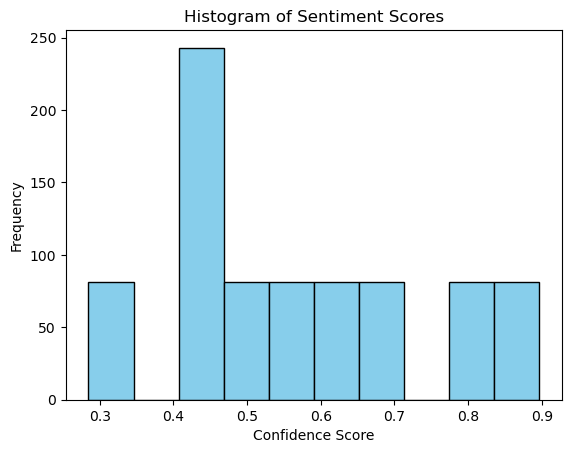

In [13]:
import matplotlib.pyplot as plt

# Histogram of sentiment scores
plt.hist(df['Confidence'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Scores')
plt.show()

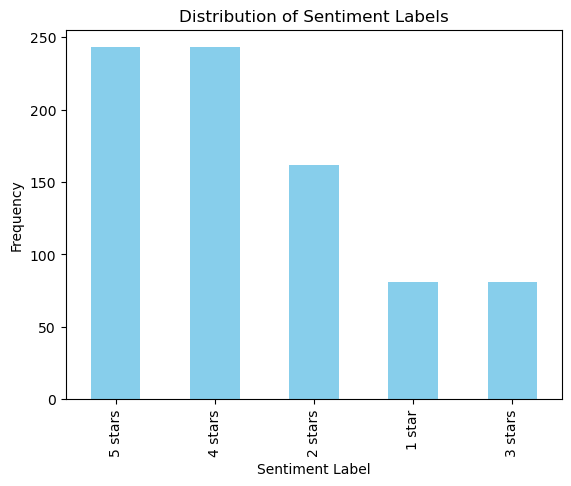

In [14]:
# Bar plot of sentiment labels
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Sentiment Label')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.show()

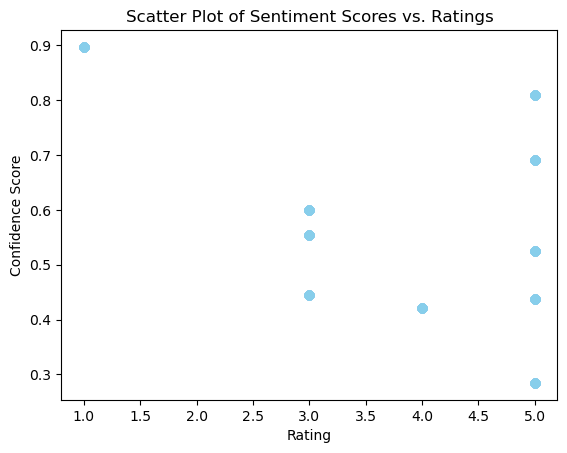

In [15]:
# Convert Rating column to numeric
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Scatter plot of sentiment scores vs. ratings
plt.scatter(df['Rating'], df['Confidence'], color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Confidence Score')
plt.title('Scatter Plot of Sentiment Scores vs. Ratings')
plt.show()

In [16]:
from wordcloud import WordCloud
# Function to generate word cloud for a specific rating range
def generate_word_cloud(reviews_text, title):
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviews_text)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

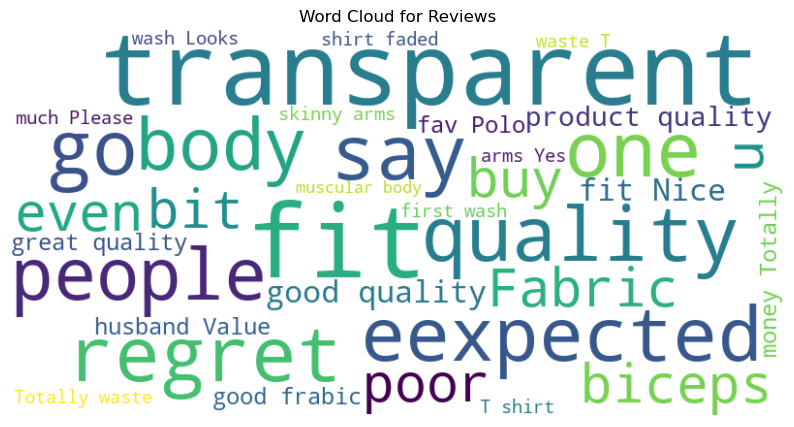

In [17]:
all_reviews_text = ' '.join(df['Review Text'])
generate_word_cloud(all_reviews_text, 'Word Cloud for Reviews')

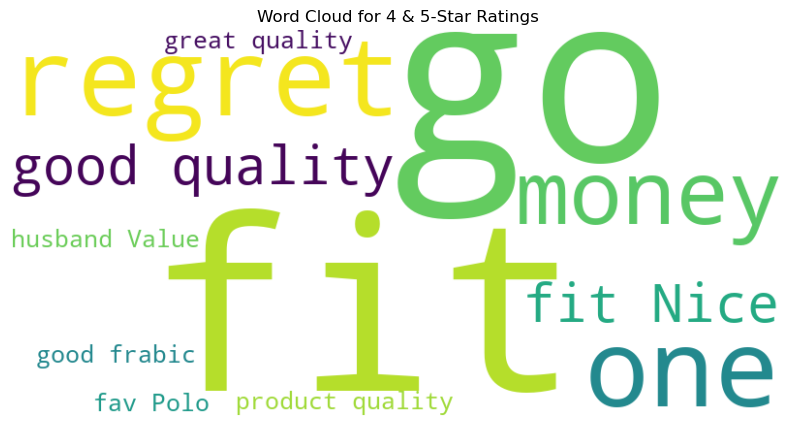

In [18]:
# Filter reviews for 5 & 4-star ratings
high_ratings_text = ' '.join(df[df['Rating'].isin([4, 5])]['Review Text'])
generate_word_cloud(high_ratings_text, 'Word Cloud for 4 & 5-Star Ratings')

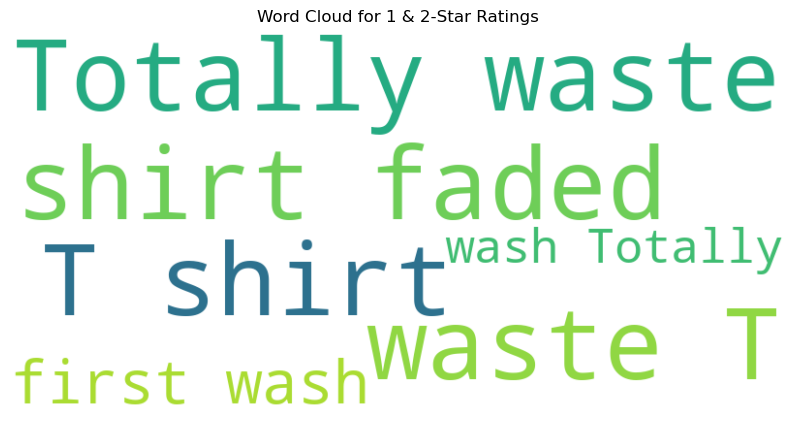

In [19]:
# Filter reviews for 1 & 2-star ratings
low_ratings_text = ' '.join(df[df['Rating'].isin([1, 2])]['Review Text'])
generate_word_cloud(low_ratings_text, 'Word Cloud for 1 & 2-Star Ratings')

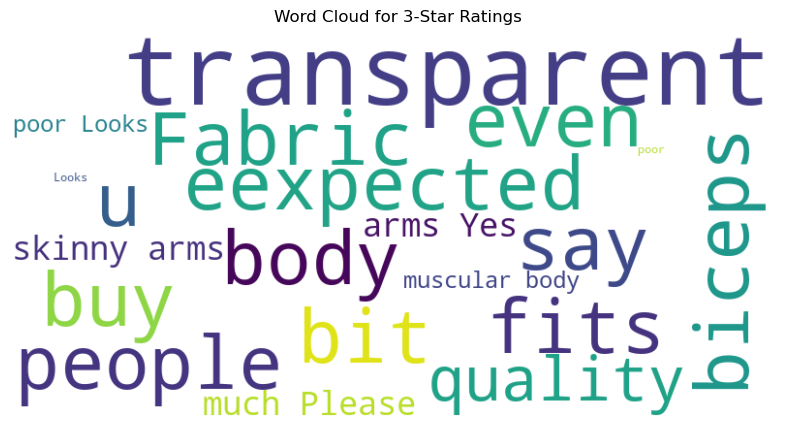

In [20]:
# Filter reviews for 3-star ratings
neutral_ratings_text = ' '.join(df[df['Rating'].isin([3])]['Review Text'])
generate_word_cloud(neutral_ratings_text, 'Word Cloud for 3-Star Ratings')